# CNN for rock-paper-scissors with Keras/TensorFlow

Date: December 6 and December 31, 2018

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [57]:
DATA_FOLDER = '../thermography/data/'

FILES = 56
TRAINING_FILES = 40
TEST_FILES = FILES - TRAINING_FILES

In [58]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [59]:
# Normalization
def scale(data):
    min_ = np.min(data)
    max_ = np.max(data)
    mean = (max_ + min_) / 2.0
    range_ = (max_ - min_) / 2.0
    data = (data - mean)/range_
    return data

In [60]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #training_set.append((pp.scale(data), class_number))
            training_set.append((scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #test_set.append((pp.scale(data), class_number))
            test_set.append((scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


array([[-0.86013986, -0.87412587, -0.87412587, ..., -0.93006993,
        -0.91608392, -0.9020979 ],
       [-0.87412587, -0.87412587, -0.88811189, ..., -0.91608392,
        -0.9020979 , -0.9020979 ],
       [-0.87412587, -0.88811189, -0.88811189, ..., -0.91608392,
        -0.91608392, -0.91608392],
       ...,
       [-0.52447552, -0.44055944, -0.32867133, ..., -0.60839161,
        -0.62237762, -0.60839161],
       [-0.53846154, -0.45454545, -0.37062937, ..., -0.59440559,
        -0.62237762, -0.60839161],
       [-0.53846154, -0.48251748, -0.42657343, ..., -0.60839161,
        -0.62237762, -0.62237762]])

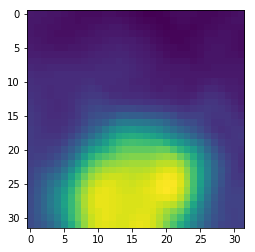

In [61]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 32, 32, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 32, 32, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,0])
train_data[12,:,:,0]

### CNN model

In [62]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3459      
Total para

In [63]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

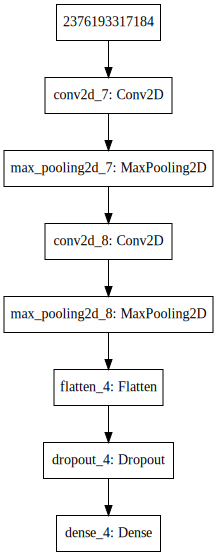

In [64]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [65]:
EPOCHS = 50
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 120 samples, validate on 48 samples
Epoch 1/50
120/120 [==============================] - 3s 25ms/step - loss: 1.0687 - acc: 0.4417 - val_loss: 1.0186 - val_acc: 0.6042
Epoch 2/50
120/120 [==============================] - 2s 15ms/step - loss: 1.0410 - acc: 0.5083 - val_loss: 0.9700 - val_acc: 0.6458
Epoch 3/50
120/120 [==============================] - 2s 18ms/step - loss: 0.9955 - acc: 0.5417 - val_loss: 0.9225 - val_acc: 0.6042
Epoch 4/50
120/120 [==============================] - 2s 20ms/step - loss: 0.9177 - acc: 0.6250 - val_loss: 0.8824 - val_acc: 0.7292
Epoch 5/50
120/120 [==============================] - 2s 17ms/step - loss: 0.8640 - acc: 0.6667 - val_loss: 0.8284 - val_acc: 0.5833
Epoch 6/50
120/120 [==============================] - 2s 19ms/step - loss: 0.8797 - acc: 0.6333 - val_loss: 0.8327 - val_acc: 0.5833
Epoch 7/50
120/120 [==============================] - 2s 18ms/step - loss: 0.8377 - acc: 0.6833 - val_loss: 0.7856 - val_acc: 0.6458
Epoch 8/50
120/120 [====

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


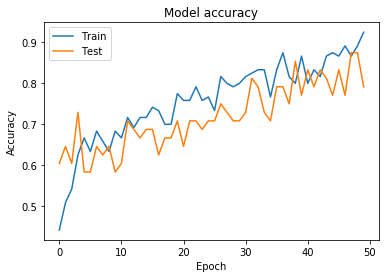

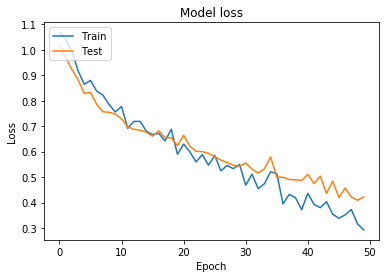

In [66]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [67]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_rock_paper_scissors_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [68]:
del model
model = models.load_model(filename)

## Confirmation

In [69]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(120, 32, 32, 1)

In [70]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [71]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [72]:
class_labels

['paper', 'rock', 'scissors']

In [73]:
(activations[-1][:10]*100).astype(int)

array([[30, 22, 46],
       [ 2,  5, 92],
       [ 1,  5, 93],
       [94,  4,  0],
       [ 0,  0, 98],
       [ 3, 95,  1],
       [ 1, 98,  0],
       [26, 39, 33],
       [73, 24,  2],
       [23, 76,  0]])

In [74]:
test_labels[:10].astype(int)

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [75]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'paper'

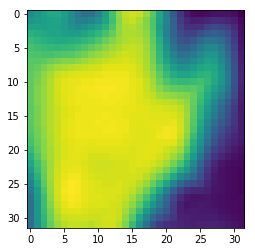

In [76]:
image_number = 10

plt.imshow(test_data[image_number,:,:,0])
class_labels[np.argmax(test_labels[image_number])]

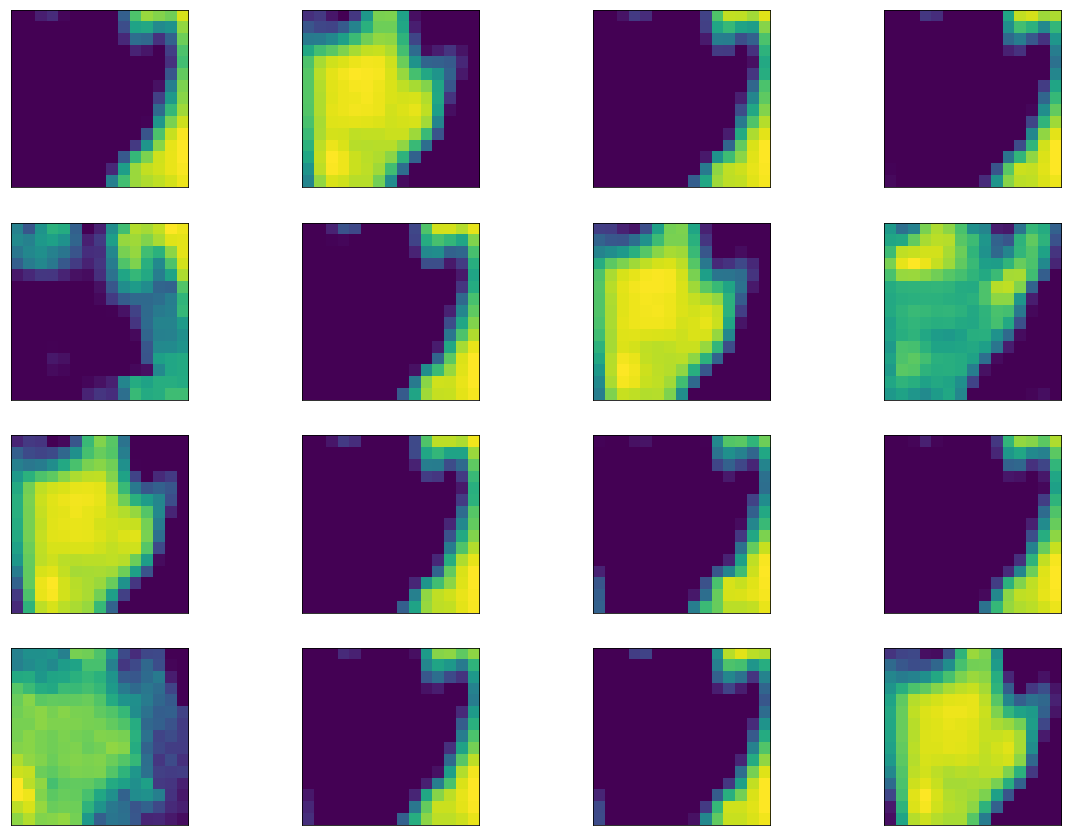

In [77]:
plot_layer(activations, image_number, 1)

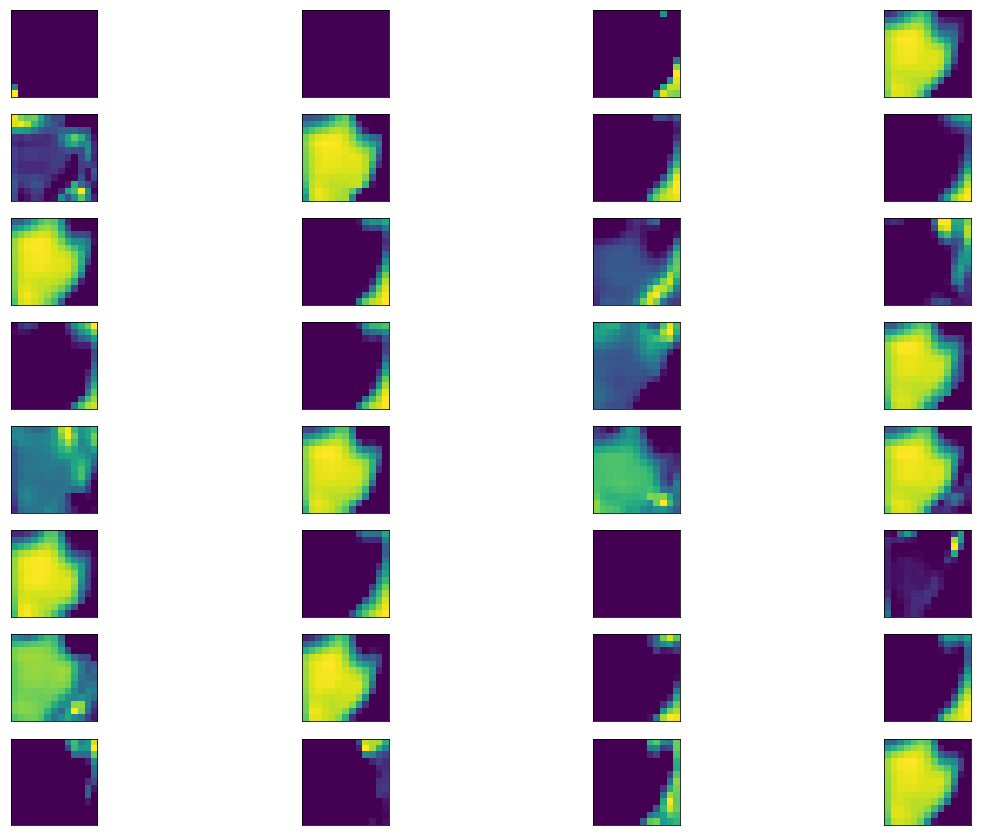

In [78]:
plot_layer(activations, image_number, 2)

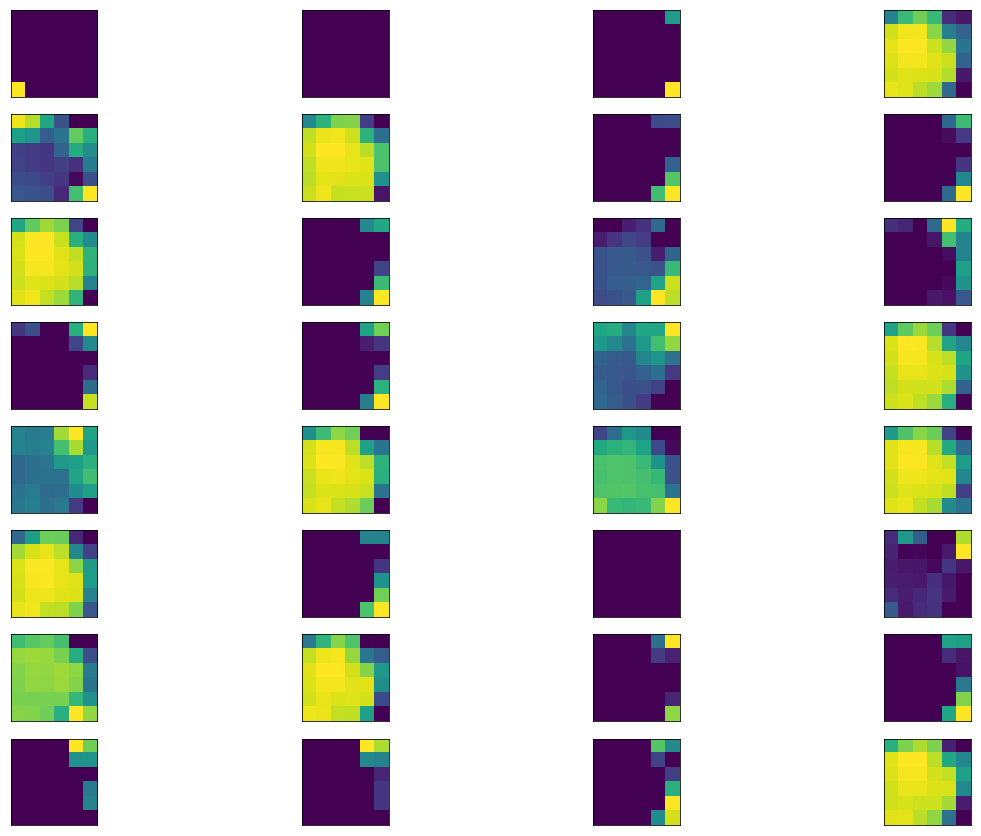

In [79]:
plot_layer(activations, image_number, 3)